In [1]:
import torch
import torch.nn as nn

In [2]:
import json


class Config:
    def __init__(self,**params):
        self.config=params
        self.set_attr()
    def update(self,**params):
        self.config.update(params)
        self.set_attr()
    def read(self,path):
        with open(path, "r") as f:
            self.config=json.load(f)
        self.set_attr()
    def save(self,path):
        with open(path,mode='w') as f:
            json.dump(self.cofig,f)
    def __str__(self):#展示config
        res=[]
        for key,val in self.config.items():
            if len(str(val))> 30:
                continue
            res.append(f"{key} : {val} ")
        return "\n".join(res)
    def set_attr(self,):
        for key, value in self.config.items():
            setattr(self, key, value)#设置字典为成员变量
config=Config(
    batch_size=16,
    seq_length=18,
    device= 'cuda' if torch.cuda.is_available() else 'cpu',
    train_val=0.9,
    epochs=20
)
print(config)

batch_size : 16 
seq_length : 18 
device : cuda 
train_val : 0.9 
epochs : 20 


In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=1, num_layers=2, dropout=0.5):
        super().__init__()
        #(seq_len, batch_size, input_size)
        self.input_size = input_size#数据维度
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers, 
            dropout=(0 if num_layers == 1 else dropout)  # apply dropout if num_layers > 1
        )
        
        self.classifer=nn.Sequential(
            nn.Dropout(),
            nn.Linear(hidden_size,output_size),
            nn.Sigmoid()

        )
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        lstm_out=lstm_out[-1]
        out=self.classifer(lstm_out)
        
        return out#(batch_size,output_size)



In [4]:
model = LSTM(input_size=2,output_size=3)
input_seq = torch.tensor([[1,2],[3,3],[4,1],[2,4],[2,3]], dtype=torch.float32).reshape(-1, 1, 2)  # Added dtype and an extra dimension for input_size
print(f"input_seq的shape为:{input_seq.shape}")
out = model(input_seq)
print(f"模型输出的shape为:{out.shape}")

input_seq的shape为:torch.Size([5, 1, 2])
模型输出的shape为:torch.Size([1, 3])


In [5]:
import string

# 定义字符集合
chars = string.ascii_lowercase + string.digits  # 'abcdefghijklmnopqrstuvwxyz0123456789'
char_to_index = {char: i for i, char in enumerate(chars)}
seq_length=config.seq_length
def encoder(text,seq_length=seq_length):
    if not isinstance(text,str):
        text=str(text)
    text=text.strip()
    return list(map(lambda x:int(x),list("0"*(seq_length-len(text))+text)))
def decoder(text,seq_length=20):
    pass
print(encoder(114514))


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 5, 1, 4]


In [6]:
import random

def createDataset(n=1000,max_num=9999999999999,func=lambda x:x%2==0):
    #生成n个在max_num中随机取样的数据
    data=random.sample(range(max_num), n)
    dataset=[
        (encoder(x),[1]) if func(x) else (encoder(x),[0]) for x in data 
    ]
    return dataset

all_data=createDataset(20000)
train_val_sep=int(config.train_val*len(all_data))
train_data=all_data[:train_val_sep]
test_data=all_data[train_val_sep:]
print(len(train_data))
print(len(test_data))
print(createDataset(n=500)[:2])


18000
2000
[([0, 0, 0, 0, 0, 4, 9, 5, 6, 4, 0, 5, 5, 5, 2, 2, 4, 9], [0]), ([0, 0, 0, 0, 0, 4, 4, 6, 1, 1, 4, 1, 9, 4, 7, 4, 0, 8], [1])]


In [7]:
from torch.utils.data import Dataset,DataLoader
class MyDataset(Dataset):#时间序列数据集
    def __init__(self,data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        seq=self.data[index][0]
        label=self.data[index][1]#seq_len长的数据预测下一个点
        return [
            torch.FloatTensor(#输入全是float
                seq,
            ).reshape(-1,1),
            torch.FloatTensor(
                label,
            ).reshape(-1,1)
        ]#返回一个序列和下一个预测值
train_dataset=MyDataset(train_data)
val_dataset=MyDataset(test_data)

print(train_dataset[0])
batch_size=config.batch_size
train_loader=DataLoader(train_dataset,batch_size=batch_size,drop_last=True)
#dataloader 添加了一个batch的维度
val_loader=DataLoader(val_dataset,batch_size=batch_size,drop_last=True)
#维度说明，一行一个向量表示输入的维度为1，有n个数据
0


[tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [8.],
        [4.],
        [4.],
        [1.],
        [9.],
        [4.],
        [8.],
        [5.],
        [1.],
        [9.],
        [5.],
        [6.],
        [1.]]), tensor([[0.]])]


0

In [8]:
device=config.device
epochs=config.epochs
model=LSTM().to(device)
loss_function=nn.BCELoss()#交叉熵
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)#优化器

In [9]:
def val(val_loader,model,epoch):
    model.eval()
    total_acc = 0
    with torch.no_grad():
        for i,(data,label) in enumerate(val_loader):
            data=data.permute(1,0,2).to(device)
            label=label.to(device).float()
            out=model(data)
            label=label.squeeze(1)
            
            out[out >= 0.5] = 1
            out[out < 0.5] = 0

            correct_preds = (out == label).float().sum().item()
            num=torch.ones_like(out).sum().item()#标签数
            total_acc += correct_preds/num
        acc=total_acc/len(val_loader)
        return acc
val(val_loader,model,1)

0.5045

In [10]:
class BestSelector:
    def __init__(self,**params):
        self.usedCnt=0
        self.bestMetrics=params
    def __getitem__(self,key):
        return self.bestMetrics[key]
    def update(self,**params):
        self.bestMetrics=params
    def __str__(self):
        res=[]
        for key,val in self.bestMetrics.items():
            if len(str(val))> 100:
                continue
            res.append(f"{key} : {val} ")
        return ",".join(res)
    



In [11]:
bestMod=BestSelector(acc=0)

In [12]:
from tqdm import tqdm
loss_list=[]
acc_list=[]#记录每次epoch的loss和acc

for epoch in tqdm(range(epochs)):    
    #train
    model.train()
    for seq,label in train_loader:
        #torch的LSTM输入格式为(seq_len, batch_size, input_size)
        #但是Dataloader封装后的格式为(batch_size, seq_len, input_size),交换0，1维度
        seq=seq.permute(1,0,2).to(device)
        label=label.to(device)

        optimizer.zero_grad()
        y_pred=model(seq)
        label=label.squeeze(1)#对齐维度
        loss=loss_function(y_pred,label)
        loss.backward()
        optimizer.step()
    #val 
    acc=val(val_loader,model,epoch=epoch)
    if acc>=bestMod['acc']:#更新best模型
        bestMod.update(
            model=model,
            acc=acc,
            epoch=epoch,
            loss=loss
        )
    
    loss_list.append(loss.to("cpu").item())
    acc_list.append(acc)
    print(f'epoch:{epoch},acc:{acc},loss:{loss}')
print("已保存最好的模型为",bestMod)
model=bestMod['model']#

  5%|▌         | 1/20 [00:03<00:59,  3.16s/it]

epoch:0,acc:0.547,loss:0.6516034603118896


 10%|█         | 2/20 [00:06<01:01,  3.40s/it]

epoch:1,acc:0.536,loss:0.6378206014633179


 15%|█▌        | 3/20 [00:10<00:59,  3.51s/it]

epoch:2,acc:0.6175,loss:0.4526442587375641


 20%|██        | 4/20 [00:14<00:57,  3.60s/it]

epoch:3,acc:0.6335,loss:0.4313124120235443


 25%|██▌       | 5/20 [00:17<00:52,  3.53s/it]

epoch:4,acc:0.6675,loss:0.33697277307510376


 30%|███       | 6/20 [00:20<00:48,  3.47s/it]

epoch:5,acc:0.713,loss:0.29988956451416016


 35%|███▌      | 7/20 [00:24<00:44,  3.42s/it]

epoch:6,acc:0.7935,loss:0.2417566478252411


 40%|████      | 8/20 [00:27<00:40,  3.35s/it]

epoch:7,acc:0.8745,loss:0.2508448660373688


 45%|████▌     | 9/20 [00:30<00:35,  3.25s/it]

epoch:8,acc:0.8315,loss:0.24763654172420502


 50%|█████     | 10/20 [00:33<00:31,  3.17s/it]

epoch:9,acc:0.8115,loss:0.19101396203041077


 55%|█████▌    | 11/20 [00:36<00:27,  3.10s/it]

epoch:10,acc:0.804,loss:0.15856443345546722


 60%|██████    | 12/20 [00:39<00:24,  3.07s/it]

epoch:11,acc:0.7955,loss:0.15881438553333282


 65%|██████▌   | 13/20 [00:42<00:21,  3.07s/it]

epoch:12,acc:0.9025,loss:0.709356963634491


 70%|███████   | 14/20 [00:45<00:18,  3.07s/it]

epoch:13,acc:0.9055,loss:0.09902621805667877


 75%|███████▌  | 15/20 [00:48<00:15,  3.07s/it]

epoch:14,acc:0.9055,loss:0.12248563766479492


 80%|████████  | 16/20 [00:51<00:12,  3.03s/it]

epoch:15,acc:0.904,loss:0.11656815558671951


 85%|████████▌ | 17/20 [00:54<00:09,  3.03s/it]

epoch:16,acc:0.9055,loss:0.0710267424583435


 90%|█████████ | 18/20 [00:57<00:06,  3.04s/it]

epoch:17,acc:0.9055,loss:0.055990785360336304


 95%|█████████▌| 19/20 [01:00<00:03,  3.14s/it]

epoch:18,acc:0.981,loss:0.05436510220170021


100%|██████████| 20/20 [01:03<00:00,  3.20s/it]

epoch:19,acc:1.0,loss:0.07841356098651886
已保存最好的模型为 acc : 1.0 ,epoch : 19 ,loss : 0.07841356098651886 


In [13]:
print(bestMod)
model=bestMod["model"]
torch.save(model.state_dict(), "best.pth")

acc : 1.0 ,epoch : 19 ,loss : 0.07841356098651886 


In [14]:
model=LSTM()
model.load_state_dict(torch.load("best.pth"))

<All keys matched successfully>

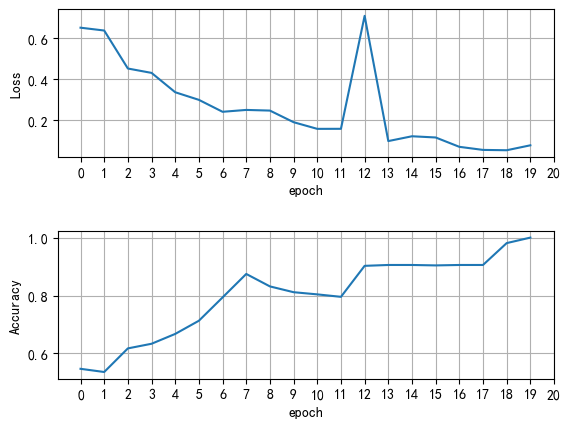

In [15]:
import matplotlib.pyplot  as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 例如设置为 'SimHei'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
# loss_list=[loss.to("cpu").item() for loss in loss_list if not isinstance(loss,float)]

plt.subplot(211)
plt.plot(loss_list)
plt.xticks((range(0,epochs+1)))
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.grid(True)


plt.subplot(212)
plt.plot(acc_list)
plt.xticks((range(0,epochs+1)))
plt.ylabel("Accuracy")
plt.xlabel("epoch")

plt.grid(True)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [17]:

def e2e_test(inputs,model_ori):
    model=model_ori.to("cpu")
    total_acc,total_num=0,0
    for seq in inputs:
        num=seq
        if seq%2==0:
            label=1
        else:
            label=0
        seq=encoder(seq)
        seq=torch.FloatTensor(seq).reshape(-1,1,1)#lstm(seq_len,batch_size,input_size)
        pred=model(seq).flatten().item()#将模型推理结果展平为普通数值格式
        if pred>=0.5:
            pred=1
            print(f"{num}是偶数")
        else:
            pred=0
            print(f"{num}是奇数")
        if label==pred:
            total_acc+=1
        total_num+=1
    acc=total_acc/total_num

    print(f"acc:{acc}")
inputs=random.sample(range(1000000),15)
e2e_test(inputs,model)

        # 



677540是偶数
295550是偶数
60084是偶数
221055是奇数
182025是奇数
419088是偶数
228735是奇数
251225是奇数
341171是奇数
463588是偶数
28112是偶数
29478是偶数
842427是奇数
11961是奇数
604104是偶数
acc:1.0
